In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle
import pandas as pd

def get_quantile(samples,q,dim=1):
    return torch.quantile(samples,q,dim=dim).cpu().numpy()

## Trajectory

In [2]:
dataset = 'trajectory' # choose 'healthcare' or 'airquality'
datafolder = 'trajectory_validationindex0_20240202_145426' # set the folder name
nsample = 5 # number of generated sample

path = './save/'+datafolder+'/generated_outputs_nsample' + str(nsample) + '.pk'
with open(path, 'rb') as f:
    samples,all_target,all_evalpoint,all_observed,all_observed_time,scaler,mean_scaler = pickle.load(f)

all_target_np = all_target.cpu().numpy()
all_evalpoint_np = all_evalpoint.cpu().numpy()
all_observed_np = all_observed.cpu().numpy()
all_given_np = all_observed_np - all_evalpoint_np

K = samples.shape[-1] #feature
L = samples.shape[-2] #time length


qlist =[0.05,0.25,0.5,0.75,0.95]
quantiles_imp= []
for q in qlist:
    quantiles_imp.append(get_quantile(samples, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np)



result_path = './save/'+datafolder+'/result_nsample' + str(nsample) + '.pk'
with open(result_path, 'rb') as f:
    RMSE, MAE, CRPS = pickle.load(f)

In [3]:
print(samples.shape)
print(quantiles_imp[2][0,:,1])

torch.Size([19, 5, 10, 3])
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00 -3.6781433e-03  0.0000000e+00  0.0000000e+00
  1.2525834e-05  2.4949939e-05]


In [4]:
print(f"RMSE = {RMSE}")
print(f"MAE = {MAE}")
print(f"CRPS = {CRPS}")

RMSE = 2.608477175419551
MAE = 1.1214066221002947
CRPS = 0.054924770405417996


In [5]:
all_target_np.shape

(19, 10, 3)

In [6]:
def visualize_trajectory(dataind, nrows=2, ncols=3):
    plt.rcParams["font.size"] = 16
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(18.0, 6.0))
    fig.delaxes(axes[-1][-1])

    for k in range(K):
        df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
        df = df[df.y != 0]
        df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
        df2 = df2[df2.y != 0]
        row = k // ncols
        col = k % ncols
        axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='CSDI')
        axes[row][col].fill_between(range(0,L), quantiles_imp[1][dataind,:,k],quantiles_imp[3][dataind,:,k],
                        color='g', alpha=0.3) # 1Q and 3Q
        axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
        axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
        plt.setp(axes[row,col], xlabel='time in 0.1s')
        if col == 0:
            plt.setp(axes[row,col], ylabel='position')
        elif col == 1:
            plt.setp(axes[row,col], ylabel='speed')
        elif col == 2:
            plt.setp(axes[row,col], ylabel='acceleration')
        axes[row,col].spines[['right', 'top']].set_visible(False)

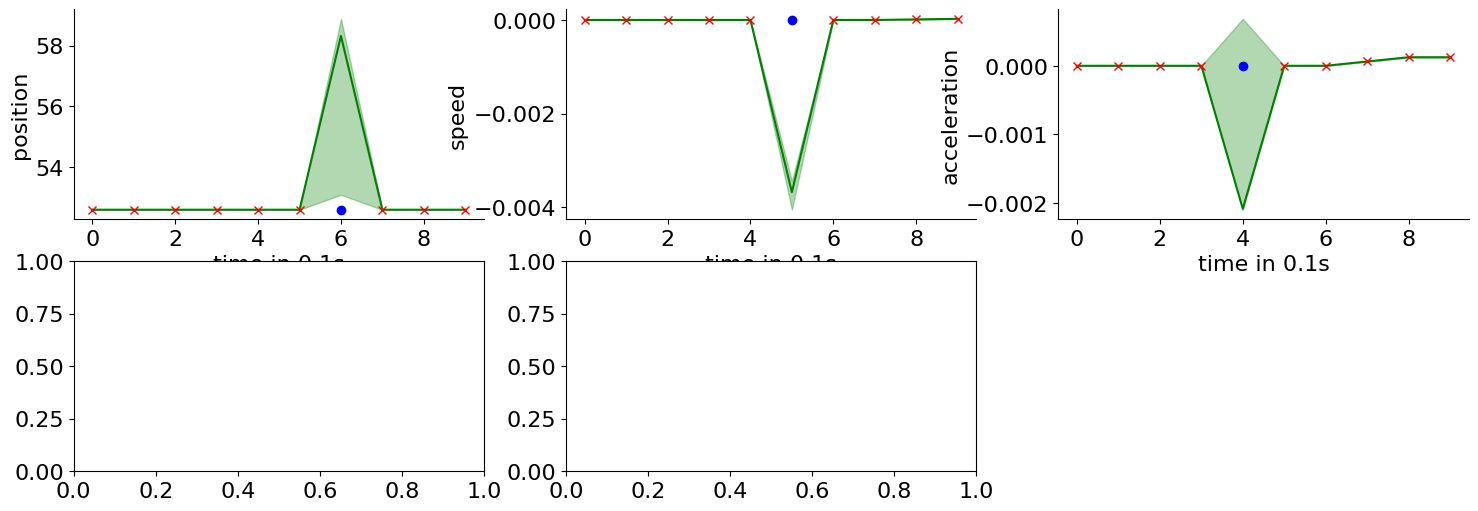

In [7]:
visualize_trajectory(dataind=0) # change to visualize a different sample

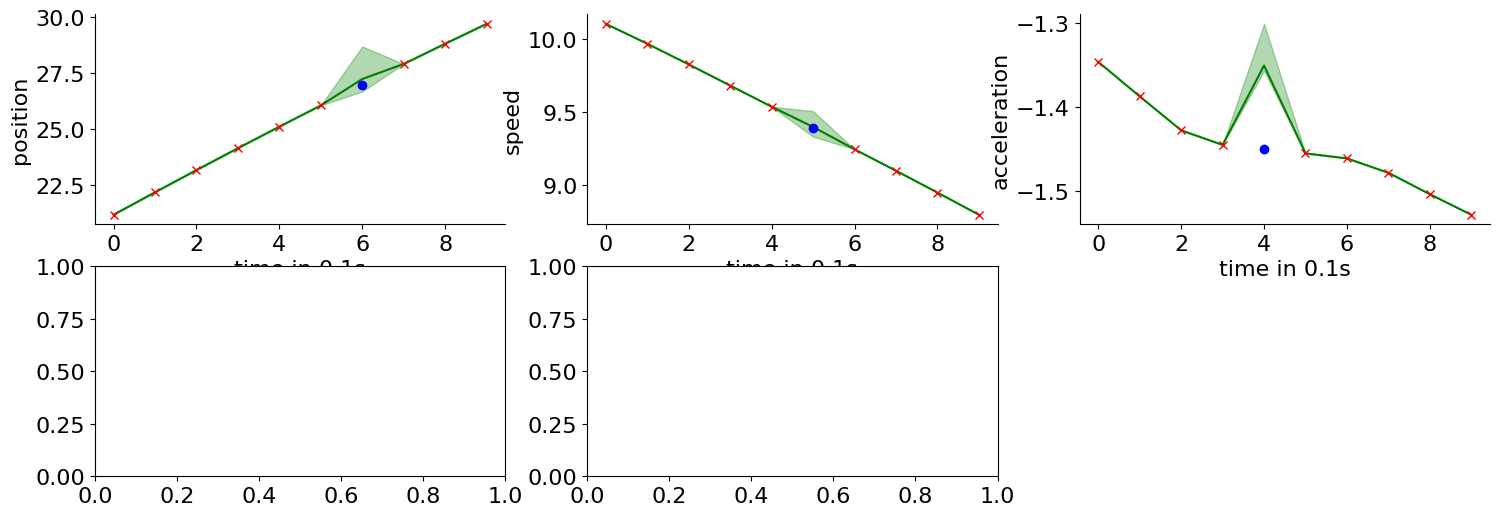

In [8]:
visualize_trajectory(dataind=1) # change to visualize a different sample

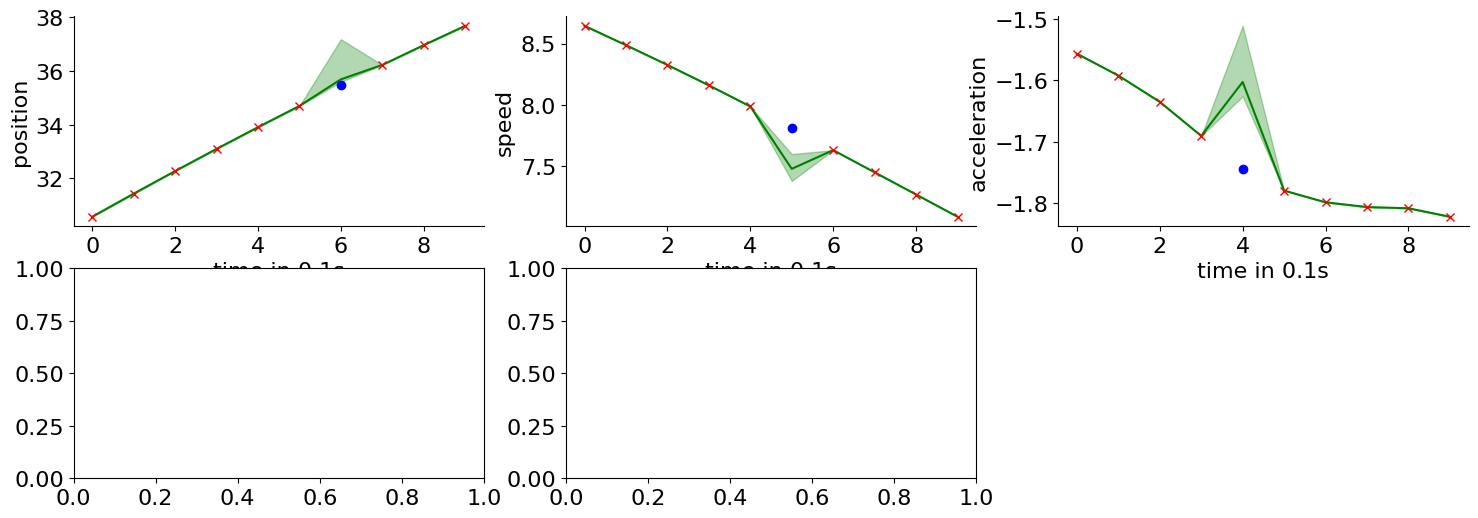

In [9]:
visualize_trajectory(dataind=2) # change to visualize a different sample

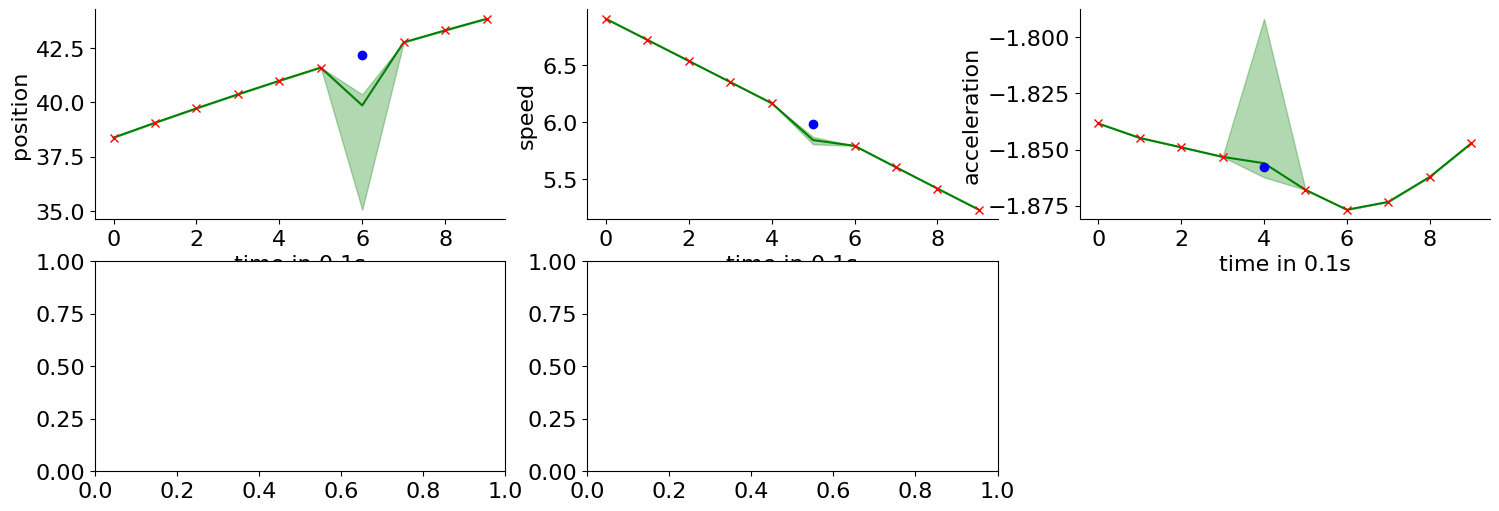

In [10]:
visualize_trajectory(dataind=3) # change to visualize a different sample

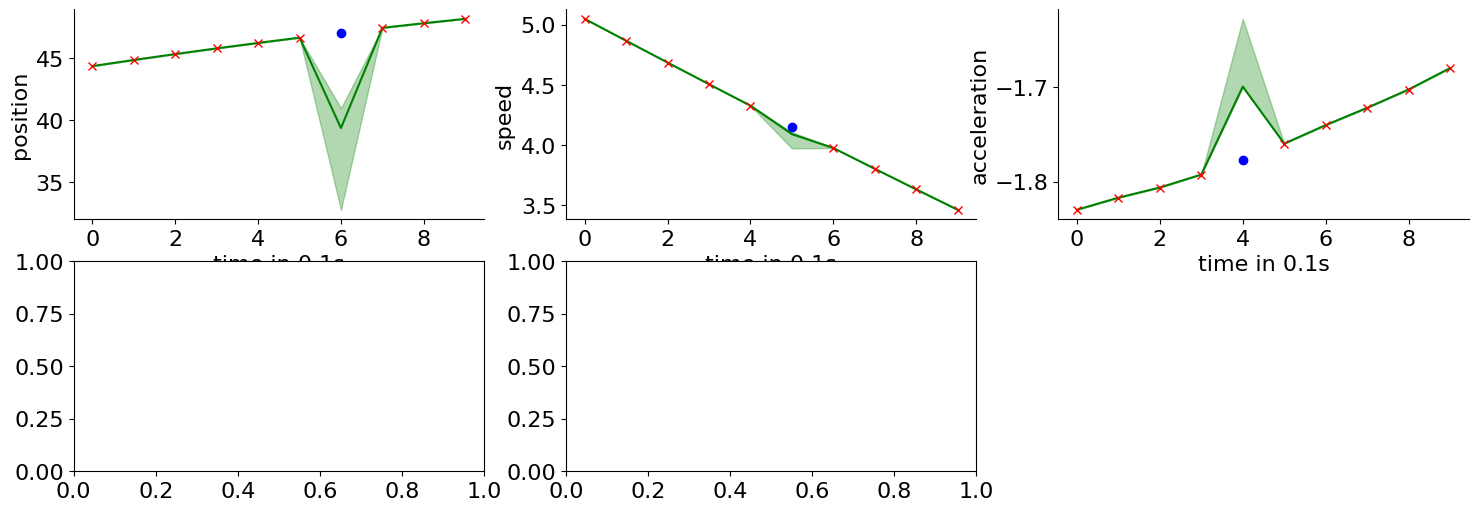

In [11]:
visualize_trajectory(dataind=4) # change to visualize a different sample

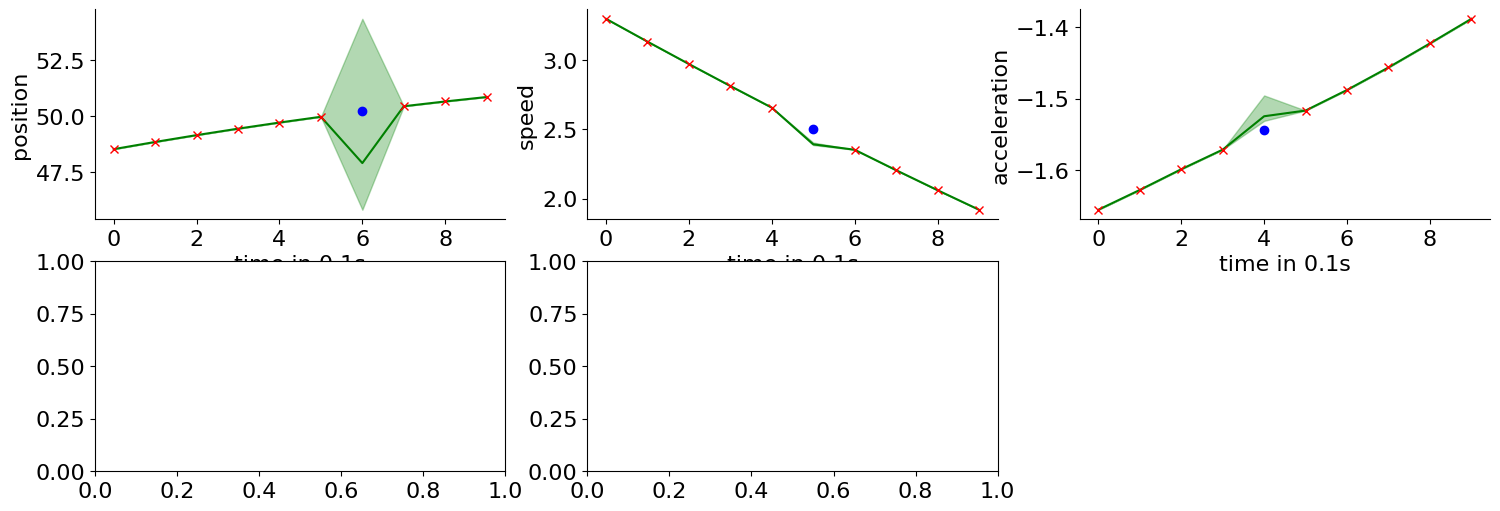

In [12]:
visualize_trajectory(dataind=5) # change to visualize a different sample

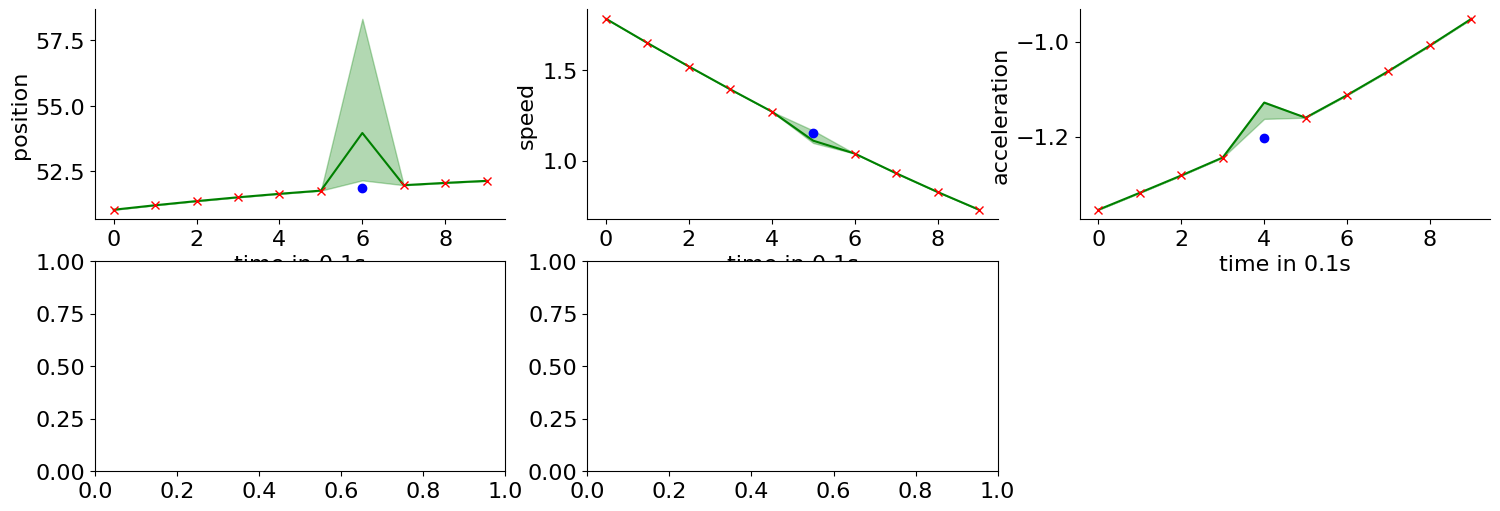

In [13]:
visualize_trajectory(dataind=6) # change to visualize a different sample

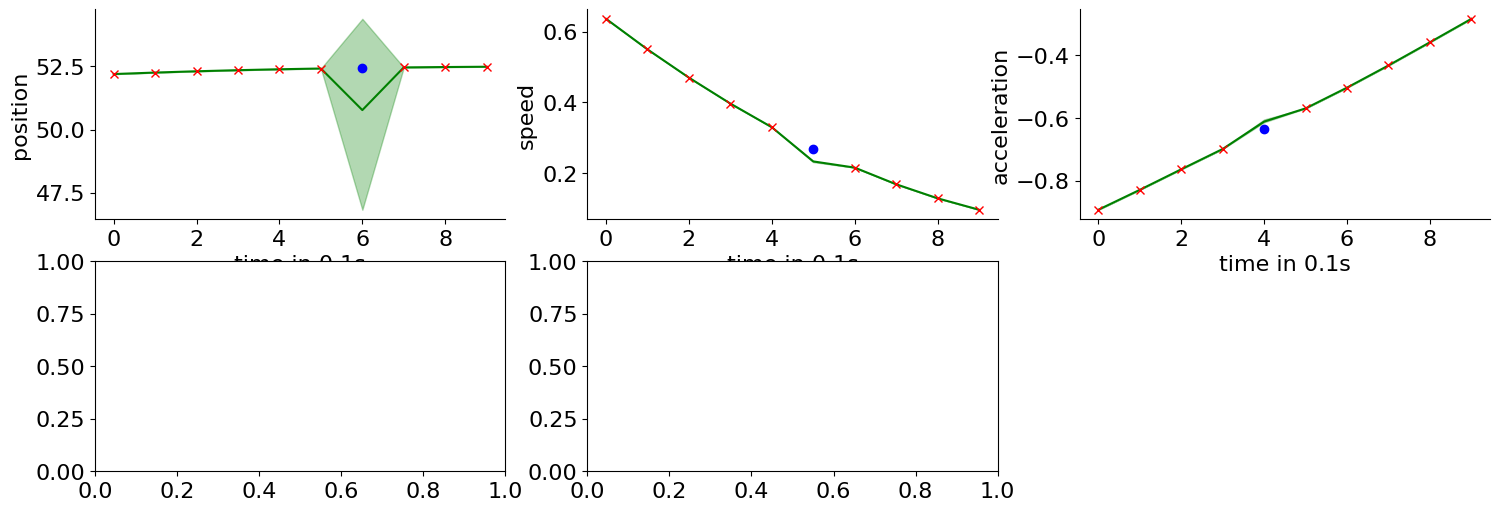

In [14]:
visualize_trajectory(dataind=7) # change to visualize a different sample

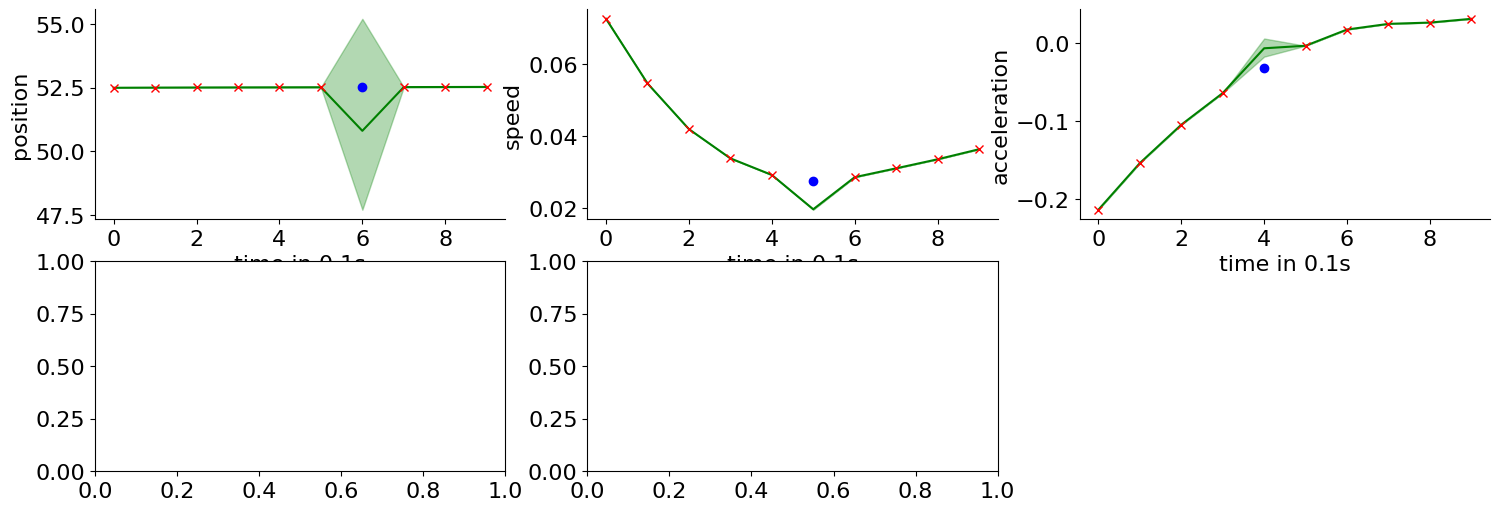

In [15]:
visualize_trajectory(dataind=8) # change to visualize a different sample

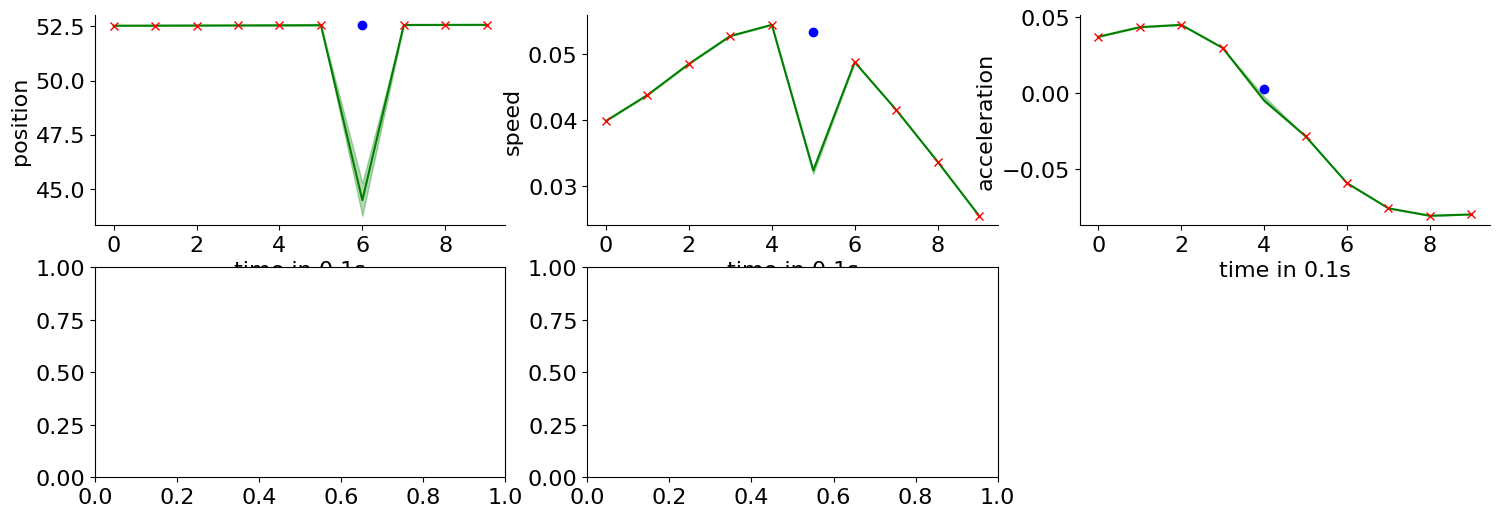

In [16]:
visualize_trajectory(dataind=9) # change to visualize a different sample

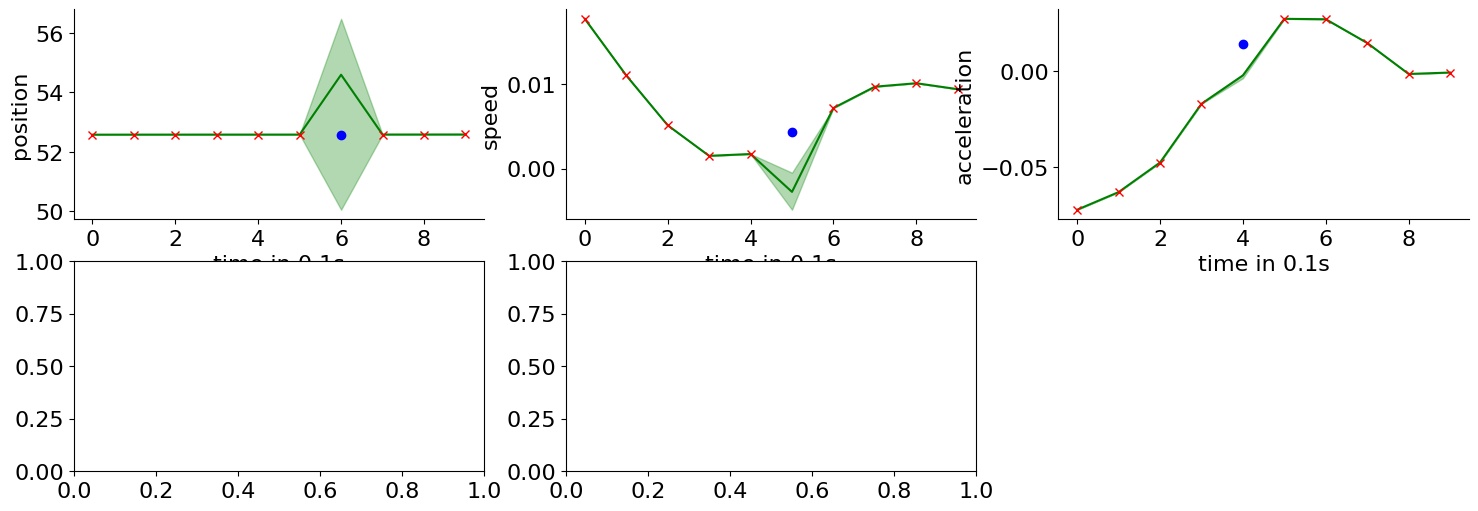

In [17]:
visualize_trajectory(dataind=10) # change to visualize a different sample